In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import re
import preprocessor as p


In [2]:
#chunksize = 10 ** 8

#btcdata = pd.read_csv('../data/interim/copy/bitcoin_engage_tweets_search_result_temp.csv')
#btcdata = pd.read_csv('../data/raw/btc-tweets-2016-2019/tweets.csv', sep='delimiter', header=None, low_memory=False)
#btcdata = pd.read_csv('../data/interim/bitcoin_all_tweets_search_result.csv')
btcTrainData = pd.read_csv('../data/interim/bitcoin_all_tweets_search_result_20211001-20220130.csv')



In [3]:

btcTrainData = btcTrainData[['id', 'date', 'text', 'hashtags', 'replyCount', 'retweetCount',
'likeCount', 'userName', 'userFollowerCount', 'userFavCount', 'userFriendCount']]
print(btcTrainData.shape)
btcTrainData.info()


(9168747, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168747 entries, 0 to 9168746
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   id                 int64 
 1   date               object
 2   text               object
 3   hashtags           object
 4   replyCount         int64 
 5   retweetCount       int64 
 6   likeCount          int64 
 7   userName           object
 8   userFollowerCount  int64 
 9   userFavCount       int64 
 10  userFriendCount    int64 
dtypes: int64(7), object(4)
memory usage: 769.5+ MB


In [4]:
#Remove duplicates based on the id
print('before dropping duplicate by id:' , btcTrainData.shape)
btcTrainData = btcTrainData.drop_duplicates(subset=['id'], keep='first')
print('after dropping duplicate by id:' , btcTrainData.shape)


before dropping duplicate by id: (9168747, 11)
after dropping duplicate by id: (9168747, 11)


In [5]:
#convert type of numeric fields
btcTrainData['replyCount'] = pd.to_numeric(btcTrainData['replyCount'], errors='coerce')
btcTrainData['retweetCount'] = pd.to_numeric(btcTrainData['retweetCount'], errors='coerce')
btcTrainData['likeCount'] = pd.to_numeric(btcTrainData['likeCount'], errors='coerce')
btcTrainData['userFollowerCount'] = pd.to_numeric(btcTrainData['userFollowerCount'], errors='coerce')
btcTrainData['userFavCount'] = pd.to_numeric(btcTrainData['userFavCount'], errors='coerce')
btcTrainData['userFriendCount'] = pd.to_numeric(btcTrainData['userFriendCount'], errors='coerce')

#convert type of text fields
btcTrainData['text'] = btcTrainData['text'].astype("string")

#btcdata.shape
btcTrainData = btcTrainData.dropna(subset=['replyCount', 'retweetCount', 'likeCount', 'userFollowerCount', 'userFavCount', 'userFriendCount'])
btcTrainData.shape
#btcdata = btcdata.astype({
    #"userFollowerCount": "int",
    #"userFavCount": "int",
    #"userFriendCount": "int",
    #"replyCount": "int",
    #"retweetCount": "int",
    #"likeCount": "int"
    #}) 


#btcdata.describe().apply(lambda s: s.apply('{0:.5f}'.format))



(9168747, 11)

In [6]:
#converting to datetime from string
btcTrainData["dateTime"] = pd.to_datetime(btcTrainData["date"], format="%Y-%m-%d %H:%M:%S", errors='coerce')

#to get rows from a period of time using dateTime
#august = btcdata[(btcdata['dateTime'] > '2021-08-01') & (btcdata['dateTime'] < '2021-09-01')]


In [7]:
btcTrainData.text[30000:40000]
#data = btcdata.astype({"text": "str"}, copy=True)
#data['text'] = data['text'].str.replace('@[\w]+', '')
#data.info()


30000    @BretWeinstein @BitcoinRadiolo1 Learn about RS...
30001    Bitcoin vulnerabilities due to mining call its...
30002    #BTC is gonna make it!!  😉 https://t.co/4k0wAw...
30003    Crypto mining won’t survive another round of e...
30004    Be weary btc is supposed to go to 25k https://...
                               ...                        
39995    Swing 🚥

$BTC 🟢 $37,805.03
$ETH 🟢 $2,569.97
$B...
39996    @stoolpresidente Why don’t you’re kick your bo...
39997      @gator_bitcoin Shorts are killing ya huh?  🤣🤣🤣🤣
39998    isthisallowed found #bitcoin in a User vault a...
39999    @jbhearn The supply is essentially fixed. Its ...
Name: text, Length: 10000, dtype: string

In [8]:
btcTrainData['text'] = btcTrainData['text'].apply(lambda x: x.lower()) #transform text to lowercase


data = btcTrainData
data.text[39999]

'@jbhearn the supply is essentially fixed. its a known. therefore demand for bitcoin is the only variable determining price. right now it is volatile, but will it be in 10 years? im guessing in 10 years bitcoin will be used more widely, and demand will be more stable.'

In [9]:
#dropping the tweets from users with no followers, friends and favourites
print('before dropping invalid users:' , data.shape)
data = data[~((data["userFollowerCount"] == 0) & (data["userFavCount"] == 0) & (data["userFriendCount"] == 0))]
#data = data.drop(data[(data["user_followers"] == 0) | (data["user_friends"] == 0) | (data["user_favourites"] == 0)].index)
print('after dropping invalid users:', data.shape)


before dropping invalid users: (9168747, 12)
after dropping invalid users: (9166500, 12)


In [10]:
#dropping the tweets with suspicious hashtags, words, bigrams, and trigrams

#any(substring in string for substring in substring_list)

#hashtags
print('before dropping by hashtags:' , data.shape)
data = data[~data.text.str.contains('#freecrypto|#freemoney|#freebitcoin|#freebtc')]
print('after dropping by hashtags:' , data.shape)

#words
print('before dropping by single keyword:' , data.shape)
data = data[~data.text.str.contains('entertaining|subscribe')]
print('after dropping by single keyword:' , data.shape)

#bigrams
print('before dropping by bigrams:' , data.shape)
data = data[~(data.text.str.contains('free bitcoin|current price|bitcoin price|earn bitcoin'))]
print('after dropping by bigrams:' , data.shape)
#data = data[~(data.text.str.contains('current') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('bitcoin') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('earn') & (data.text.str.contains('bitcoin')))]

#trigrams
print('before dropping by trigrams:' , data.shape)
data = data[~(data.text.str.contains('start trading bitcoin'))]
print('after dropping by trigrams:' , data.shape)


before dropping by hashtags: (9166500, 12)
after dropping by hashtags: (9161967, 12)
before dropping by single keyword: (9161967, 12)
after dropping by single keyword: (9151642, 12)
before dropping by bigrams: (9151642, 12)
after dropping by bigrams: (8919130, 12)
before dropping by trigrams: (8919130, 12)
after dropping by trigrams: (8919051, 12)


In [11]:
#Remove urls, mentions, hashtags, empty lines, spaces, reserved words (RT, FAV)
#keep emojis, smileys, numbers
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED)
data['text'] = data['text'].apply(lambda x: p.clean(x))



In [12]:
#Check the header of formated text
data.text[100:200]


102    why nov 2021 was not the, "true" cycle top? ✔️...
103    $btc price: $38192 $eth price: $2602 $ltc pric...
104                                  he invented bitcoin
105    criminals laundered $8.6 billion worth of cryp...
106    a panel of 33 fintech experts predict (btc) to...
                             ...                        
203    michael saylor's bitcoin average: ~$29534 prof...
204    i am super bullish because is most likely bitc...
205    started out with a value of zero and has hit h...
206                                now rewatch true lies
207    this right here is a perfect example of the gu...
Name: text, Length: 100, dtype: object

In [13]:
#remove special characters
#data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x)) 

In [14]:
#remove extra space between words
#data['text'] = data['text'].apply(lambda x: re.sub(' +', ' ', x)) 

In [15]:
#save the length of each tweets to df
data['textLength'] = data['text'].str.len()

Verify data integrity


In [16]:
# Select all duplicate rows based on one column
#duplicateRowsDF = data[data.duplicated(['id'])]

#print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')
##duplicateRowsDF

#Numbers of duplicate rows in each date
#duplicateRowsDFDate = duplicateRowsDF['dateTime'].groupby(duplicateRowsDF['dateTime'].dt.date)
#duplicateRowsDFDate.size()
print(data.shape)

#check if all the text are string
data[data['text'].map(type) == str].shape 



(8919051, 13)


(8919051, 13)

Save processed data


In [17]:
#save the processed data to csv
data.to_csv('../data/processed/bitcoin_tweets_result_processed_20211001-20220130.csv')


Display histograms of tweets length


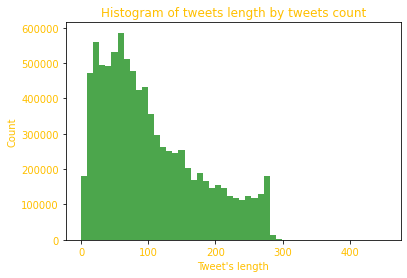

In [18]:
#display histograms of tweets length
#cols = ["user_followers", "user_friends", "user_favourites"]

#for col in cols:
col = "textLength"
#btcdata = btcdata.astype({"user_friends": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
#pos_series = btcdata[col].tolist()
#neg_series = negative_examples[col].tolist()
plt.hist(data[col], 50, facecolor='g', alpha=0.7)
#plt.hist(neg_series, 50, facecolor='r', alpha=0.7, label="0")
#plt.legend(prop={"size": 10})
plt.xlabel("Tweet's length", color='#FFC000')
plt.ylabel("Count", color='#FFC000')
plt.ticklabel_format(style='plain')
plt.tick_params(labelcolor='#FFC000')
plt.title("Histogram of tweets length by tweets count", color='#FFC000')
plt.show()

Check the total number of tweets for each day, overlay with bitcoin closing price


In [19]:
#load bitcoin pricing information
price = pd.read_csv('../data/external/BTC_USD_2020-10-10_2021-10-09-CoinDesk.csv')
pdata = price[['Date', 'Closing Price (USD)']]

In [20]:
#count number of tweets each date
df = data['dateTime'].groupby(data['dateTime'].dt.date).size().reset_index(name='count')

In [21]:
#merge two dfs by date


df = df.astype({"dateTime": "str"}) 
print(type(df['dateTime'][0]))
#print(type(pdata['Date'][0]))

#merged_df1 = pd.merge(left=df, right=pdata, left_on='dateTime', right_on='Date')
#merged_df1 = merged_df1.astype({"Closing Price (USD)": "int"}) 
#merged_df1

<class 'str'>


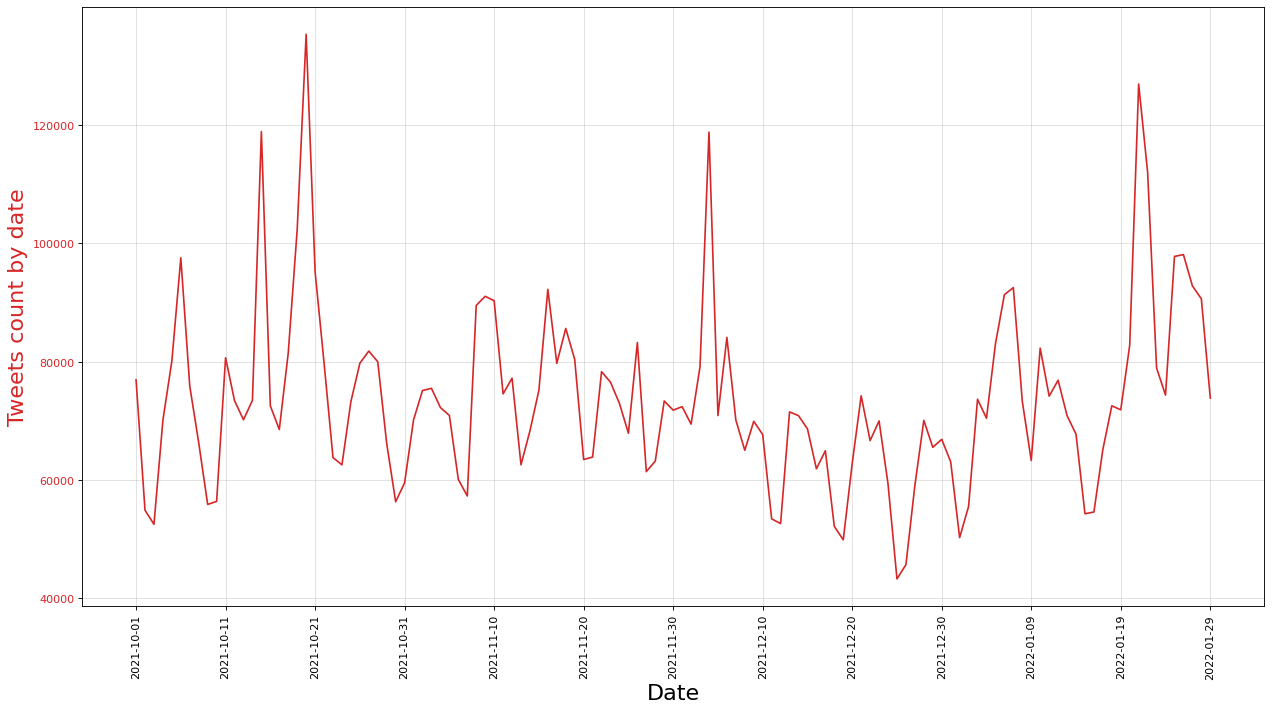

In [22]:
#x = merged_df1['dateTime']
#y1 = merged_df1['count']
#y2 = merged_df1['Closing Price (USD)']

x = df['dateTime']
y1 = df['count']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')


# Plot Line2 (Right Y Axis)
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Date', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Tweets count by date', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

ax1.set_xticks(np.arange(0, len(x), 10)) #change this number to change the number of labels
ax1.set_xticklabels(x[::10], rotation=90, fontdict={'fontsize':10}) #change this number to change the number of labels

# ax2 (right Y axis)
#ax2.set_ylabel("Bitcoin closing price (USD)", color='tab:blue', fontsize=20)
#ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.set_xticks(np.arange(0, len(x), 20)) #change this number to change the number of labels
#ax2.set_xticklabels(x[::20], rotation=90, fontdict={'fontsize':10}) #change this number to change the number of labels
#ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)
fig.tight_layout()
plt.show()




Randomly select rows from each day


In [23]:
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x :x.iloc[random.choice(range(0,len(x)))])
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x: x.sample(2)).reset_index(drop=True)

selected = data.groupby(data['dateTime'].dt.day).apply(lambda x: x.sample(10, random_state=889))

selected.to_csv('sample_bitcoin_tweets_ten_each_day.csv')
selected

id                       date  \
dateTime                                                           
1        4440283  1465943852183965697  2021-12-01 07:20:24+00:00   
         9104396  1444015825791422496  2021-10-01 19:06:16+00:00   
         4432668  1465984969713623046  2021-12-01 10:03:48+00:00   
         6728334  1455115160025112578  2021-11-01 10:11:03+00:00   
         9118536  1443958305957818370  2021-10-01 15:17:42+00:00   
...                               ...                        ...   
31       2343160  1476999129452716035  2021-12-31 19:30:08+00:00   
         2370814  1476856842877816832  2021-12-31 10:04:44+00:00   
         2332960  1477047729494835202  2021-12-31 22:43:15+00:00   
         2358824  1476927509534953475  2021-12-31 14:45:32+00:00   
         2354614  1476947900726927368  2021-12-31 16:06:34+00:00   

                                                               text  \
dateTime                                                              
1        4440283  hey this is a great to get behind! raising mon...   
         9104396  literally everyone saying $53k is the next big...   
         4432668  24-hour crypto market activity via social volu...   
         6728334  the sandbox - $sand nexo - $nexo kucoin token ...   
         9118536  would love to get in touch. this is an older f...   
...                                                             ...   
31       2343160  just fork to a new hashing algorithm. if your ...   
         2370814                                    is at 48286 usd   
         2332960  neutral. partly because i don't have a clue, p...   
         2358824                             amazing break ath soon   
         2354614  is this michael saylor a bot? he is spamming e...   

                                                           hashtags  \
dateTime                                                              
1        4440283  ['SHIBARMY', 'Ethereum', 'Bitcoin', 'dogelon',...   
         9104396                                            ['BTC']   
         4432668                       ['LunarCrush', 'LunarShare']   
         6728334                                                NaN   
         9118536                                                NaN   
...                                                             ...   
31       2343160                                                NaN   
         2370814                                        ['Bitcoin']   
         2332960                                        ['Bitcoin']   
         2358824                                ['BTC', 'SpikeInu']   
         2354614                                                NaN   

                  replyCount  retweetCount  likeCount         userName  \
dateTime                                                                 
1        4440283           0             0          0       SirRonHale   
         9104396           2             1         22         kale_abe   
         4432668           0             5          6  JiyaulH02265628   
         6728334           0             1          4        AnsariMfa   
         9118536           1             0          2       SinoCrypto   
...                      ...           ...        ...              ...   
31       2343160           1             0          1      DavidVorick   
         2370814           1             0          0        cryptokuh   
         2332960           0             0          1  Butler_Services   
         2358824           0             0          0          Katyl68   
         2354614           0             0          0  liquids17483287   

                  userFollowerCount  userFavCount  userFriendCount  \
dateTime                                                             
1        4440283               5930           546              576   
         9104396              82812         10161              522   
         4432668                 46           514          